In [1]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle
import multiprocessing
import seaborn as sns
import keras
import random
import os
from operator import itemgetter
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, Isomap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from scipy.spatial.distance import pdist, squareform
from scipy.stats import kendalltau
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

# load data

In [2]:
def load_winequality_dataset():
    path_red_wine = "./wine_quality/winequality-red.csv"
    path_white_wine = "./wine_quality/winequality-white.csv"
    
    data_red = pd.read_csv(path_red_wine, delimiter=";")
    data_white = pd.read_csv(path_white_wine, delimiter=";")
    
    data = np.vstack((data_red, data_white))
    data_x = data[:, :-1]
    data_y = [0] * data_red.shape[0] + [1] * data_white.shape[0]
    
    return data_x, np.array(data_y)


def load_credit_dataset():

    path = "./credit/credit.data"

    data = np.array(pd.read_csv(path, header=None, delimiter=","))

    data_list = []

    for index in range(data.shape[0]):
        row = [float(value) for value in data[index][0].split(" ") if value.isnumeric()]
        data_list.append(row)

    data_list = np.array(data_list)
    
    data_x = data_list[:, :-1]
    data_y = data_list[:, -1] -1
    
    return data_x, data_y


# segmentation dataset
def load_segmentation_dataset():
    path_train = "./segmentation/segmentation.data"
    path_test = "./segmentation/segmentation.test"

    data_train = np.array(pd.read_csv(path_train, header=None, delimiter=","))
    data_test = np.array(pd.read_csv(path_test, header=None, delimiter=","))

    data = np.vstack((data_train, data_test))
    data_y, data_x = data[:, 0], data[:, 1:]

    classes = np.unique(data_y)
    dic_str_to_int = dict(zip(classes, np.arange(0, len(classes), 1)))
    data_y = [dic_str_to_int[string] for string in data_y]

    return data_x, np.array(data_y)


def load_observatory_dataset():
    path = "./observatory/observatory.data"
    
    data = np.array(pd.read_csv(path, delimiter=","))
    data_y, data_x = data[:, -1], data[:, :-1]

    classes = np.unique(data_y)
    dic_str_to_int = dict(zip(classes, np.arange(0, len(classes), 1)))
    data_y = [dic_str_to_int[string] for string in data_y]
    
    return data_x, np.array(data_y)


def load_ionosphere_dataset():
    path = "./ionosphere/ionosphere.data"
    
    data = np.array(pd.read_csv(path, delimiter=","))
    data_y, data_x = data[:, -1], data[:, :-1]
    
    return data_x, data_y


def load_wine_dataset():
    path = "./wine/wine.data"
    
    data = np.array(pd.read_csv(path, delimiter=","))
    data_y, data_x = data[:, 0], data[:, 1:]
    
    return data_x, data_y


def load_libras_dataset():
    path = "./movement_libras/movement_libras.data"
    
    data = np.array(pd.read_csv(path, delimiter=","))
    data_y, data_x = data[:, -1], data[:, :-1]
    
    return data_x, data_y


def load_data(dataset):
    if dataset == "segmentation":
        data_x, data_y = load_segmentation_dataset()

    elif dataset == "credit":
        data_x, data_y = load_credit_dataset()
        
    elif dataset == "winequality":
        data_x, data_y = load_winequality_dataset()
        
    elif dataset == "observatory":
        data_x, data_y = load_observatory_dataset()
        
    elif dataset == "ionosphere":
        data_x, data_y = load_ionosphere_dataset()
        
    elif dataset == "wine":
        data_x, data_y = load_wine_dataset()
        
    elif dataset == "libras":
        data_x, data_y = load_libras_dataset()

    return data_x, data_y


# aux functions

In [3]:
def k_fold_valifation_accuracy_rf(x_low_test, y_test, n_splits=10):
    accuracy_list = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    for train_indices, val_indices in kf.split(x_low_test):
        x_train, y_train = x_low_test[train_indices], y_test[train_indices]
        x_val, y_val = x_low_test[val_indices], y_test[val_indices]
        
        scaler = StandardScaler()
        scaler = scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_val = scaler.transform(x_val)

        classifier = RandomForestClassifier()
        classifier.fit(x_train, y_train)
        predictions = classifier.predict(x_val)

        accuracy = balanced_accuracy_score(y_val, predictions)
        accuracy_list.append(accuracy)

    return np.mean(accuracy_list)

In [4]:
def compute_pareto(data):
    sorted_data = sorted(data, key=itemgetter(0,1), reverse=True)
    pareto_idx = list()
    pareto_idx.append(0)
    
    cutt_off_fitness = sorted_data[0][0]
    cutt_off_length = sorted_data[0][1]

    for i in range(1, len(sorted_data)):
        if sorted_data[i][0] > cutt_off_fitness or sorted_data[i][1] < cutt_off_length:
            pareto_idx.append(i)
            if sorted_data[i][0] > cutt_off_fitness:
                cutt_off_fitness = sorted_data[i][0]
            else:
                cutt_off_length = sorted_data[i][1]
            
    return np.array(sorted_data), pareto_idx

In [5]:
def shuffle_data(x_data, y_data, seed):
    np.random.seed(seed)
    shuffle_list = np.arange(x_data.shape[0])
    np.random.shuffle(shuffle_list)
    x_data = x_data[shuffle_list]
    y_data = y_data[shuffle_list]

    return x_data, y_data

In [6]:
def get_quantile(data, low_q):

    median = np.median(data, axis=0)
    low_quantile = np.quantile(data, low_q, axis=0)
    high_quantile = np.quantile(data, 1-low_q, axis=0)
    
    return median, low_quantile, high_quantile

In [7]:
def reconstruction_multi_output(x_low_test, x_test_org, n_splits=10):

    reconstruction_list = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    for train_indices, val_indices in kf.split(x_low_test):
        x_train, y_train = x_low_test[train_indices], x_test_org[train_indices]
        x_val, y_val = x_low_test[val_indices], x_test_org[val_indices]

        scaler = StandardScaler()
        scaler = scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_val = scaler.transform(x_val)

        model = KernelRidge(kernel='rbf')
        est = MultiOutputRegressor(model)
        est.fit(x_train, y_train)
        preds_test = est.predict(x_val)

        test_reconstruction_error = np.mean((preds_test - y_val) ** 2)

        reconstruction_list.append(test_reconstruction_error)

    return np.mean(reconstruction_list)

In [8]:
def neural_decoder_fitness(x_low_train, x_low_test, x_train_org, x_test_org):

    scaler = StandardScaler()
    scaler.fit(x_train_org)
    x_train_org = scaler.transform(x_train_org)
    x_test_org = scaler.transform(x_test_org)

    input_size = x_train_org.shape[1]
    latent_size = x_low_train.shape[1]
    initializer = keras.initializers.glorot_normal()

    model = keras.models.Sequential([

        keras.layers.Dense(int((input_size + latent_size) / 4), activation="elu", use_bias=True,
                           trainable=True, kernel_initializer=initializer),

        keras.layers.Dense(int((input_size + latent_size) / 2), activation="elu", use_bias=True,
                           trainable=True, kernel_initializer=initializer),

        keras.layers.Dense(input_size, activation=keras.activations.linear, use_bias=False,
                            trainable=True, kernel_initializer=initializer)
    ])

    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='mse', metrics=['mse'])

    model_info = model.fit(x_low_train, x_train_org, batch_size=32, epochs=200, verbose=False, validation_data=(x_low_test, x_test_org))
    training_loss = model_info.history["loss"][-1]
    test_loss = model_info.history["val_loss"][-1]

    keras.backend.clear_session()

    return training_loss, test_loss

# plots for n independent runs

In [10]:
dataset = "segmentation"

dimensions = [2]

In [100]:
original_list_accuracy = []
teacher_list_accuracy = []
teacher_list_reconstruction = []

gp_fitness_training_error = []
gp_fitness_testing_error = []

gp_length_list = []
gp_formulas = []

dic_gp_metrics = dict()

list_files = os.listdir("gecco/" + dataset)
list_files = [file for file in list_files if "200" in file and dataset + "_" + str(dimensions[0]) in file]
list_files = sorted(list(list_files))

print(list_files)

for num_latent_dimensions in dimensions:
    for file in list_files:
        results = pickle.load(open("gecco/" + dataset + "/" + file, "rb"))
        list_info = [[] for _ in range(len(results[0].keys()))]
            
        # build list from the dictionary
        for index in range(len(results)):
            count = 0
            for k in results[index].keys():
                list_info[count].append(results[index][k])
                count += 1
            
        original_list_accuracy.append(list_info[0])
        teacher_list_accuracy.append(np.array(list_info[1])[:,0])
        teacher_list_reconstruction.append(np.array(list_info[1])[:,1])
    
        # FOR THE GP RUNS
        
        array_test_info = np.array(list_info[2])[:, 0, 1]
        
        gp_formulas.append([list_info[0][-1] for list_info in array_test_info])
        
        gp_fitness_training_error.append([np.array(run)[:,0] for run in np.array(list_info[2])[:, 0, 0]])
        gp_fitness_testing_error.append([np.array(run)[:,1] for run in np.array(list_info[2])[:, 0, 0]])
            
        list_metrics = []
        for index in [0, 1, 2]:
            list_metrics.append([arr[0][index] for arr in array_test_info])
        dic_gp_metrics[file] = list_metrics  
                

['results_segmentation_2_mt_not_shared_autoencoder_teacher_fitness_length_pop=200_multi_objective=False.p', 'results_segmentation_2_mt_not_shared_manifold_fitness_rank_euclidean_length_pop=200_multi_objective=False.p', 'results_segmentation_2_mt_not_shared_manifold_fitness_rank_isomap_length_pop=200_multi_objective=False.p', 'results_segmentation_2_mt_not_shared_manifold_fitness_sammon_euclidean_length_pop=200_multi_objective=False.p', 'results_segmentation_2_mt_not_shared_manifold_fitness_sammon_isomap_length_pop=200_multi_objective=False.p', 'results_segmentation_2_mt_shared_gp_autoencoder_fitness_length_pop=200_multi_objective=False.p']


In [23]:
# get the baselines
baseline_methods = ["PCA", "Isomap", "LocallyLinearEmbedding"]

accuracy_baselines = []
reconstruction_baselines = []
neural_reconstruction_baselines = []
    
for run in range(10):
    print("Computing for run number: " + str(run))
    
    split_proportion = [0.6, 0.4]
        
    data_x, data_y = load_data(dataset)
    data_x, data_y = shuffle_data(data_x, data_y, run)
        
    train_data_x = data_x[:int(data_x.shape[0]*split_proportion[0])]
    test_data_x = data_x[int(data_x.shape[0]*split_proportion[0]):]
    
    train_data_y = data_y[:int(data_x.shape[0]*split_proportion[0])]
    test_data_y = data_y[int(data_x.shape[0]*split_proportion[0]):]

    scaler = StandardScaler()
    scaler = scaler.fit(train_data_x)
    train_data_x = scaler.transform(train_data_x)
    test_data_x = scaler.transform(test_data_x)
    
    # PCA tansformation of the original data
    est = PCA(n_components=train_data_x.shape[1])
    est.fit(train_data_x)
    explained_variance_mask = np.cumsum(est.explained_variance_ratio_) >= 0.99
    num_components = list(explained_variance_mask).index(True)
    train_data_x_pca = est.transform(train_data_x)[:, :num_components]
    test_data_x_pca = est.transform(test_data_x)[:, :num_components]
        
    accuracy_list = []
    reconstruction_list = []
    neural_reconstruction_list = []
    for method in baseline_methods:
        
        if method == "PCA":
            est = PCA(n_components=num_latent_dimensions)
        elif method == "Isomap":
            est = Isomap(n_components=num_latent_dimensions)
        elif method == "LocallyLinearEmbedding":
            est = LocallyLinearEmbedding(n_components=num_latent_dimensions, eigen_solver='dense')
            
        est.fit(train_data_x)
        train_data_x_transform = est.transform(train_data_x)
        test_data_x_transform = est.transform(test_data_x)

        # reconstruction
        decoder_loss_test = reconstruction_multi_output(test_data_x_transform, test_data_x_pca)
        reconstruction_list.append(decoder_loss_test)
        
        _, neural_decoder_loss_test = neural_decoder_fitness(train_data_x_transform, test_data_x_transform, train_data_x_pca, test_data_x_pca)
        neural_reconstruction_list.append(neural_decoder_loss_test)
        
        # accuracy
        accuracy_test = k_fold_valifation_accuracy_rf(test_data_x_transform, test_data_y)
        accuracy_list.append(accuracy_test)
        
    accuracy_baselines.append(accuracy_list)
    reconstruction_baselines.append(reconstruction_list)
    neural_reconstruction_baselines.append(neural_reconstruction_list)

Computing for run number: 0
Computing for run number: 1
Computing for run number: 2
Computing for run number: 3
Computing for run number: 4
Computing for run number: 5
Computing for run number: 6
Computing for run number: 7
Computing for run number: 8
Computing for run number: 9


# statistical testing

In [24]:
df = pd.DataFrame(dic_gp_metrics)
df.columns = ["Teacher GP",
              "Rank (Euclidean) GP",
              "Rank (Geodesic) GP",
              "Sammon (Euclidean) GP", 
              "Sammon (Geodesic) GP",
              "Autoencoder GP"]

In [25]:
df.index = ["accuracy", "kernel reconstruction", "neural reconstruction"]

In [26]:
dic_baselines = dict()
col_names = ["PCA", "Isomap", "LocallyLinearEmbedding"]

for index in range(3):
    data_list = [np.array(accuracy_baselines)[:,index], 
                 np.array(reconstruction_baselines)[:,index], 
                 np.array(neural_reconstruction_baselines)[:,index]]
        
    dic_baselines[col_names[index]] = data_list

In [27]:
df_baselines = pd.DataFrame(dic_baselines)
df_baselines.index = ["accuracy", "kernel reconstruction", "neural reconstruction"]

In [28]:
data_frame = pd.concat([df.reset_index(drop=True), df_baselines.reset_index(drop=True)], axis=1, ignore_index=True)

In [29]:
data_frame.columns = list(df.columns) + list(baseline_methods)
data_frame.index = ["accuracy", "kernel reconstruction", "neural reconstruction"]

In [30]:
data_frame

,Teacher GP,Rank (Euclidean) GP,Rank (Geodesic) GP,Sammon (Euclidean) GP,Sammon (Geodesic) GP,Autoencoder GP,PCA,Isomap,LocallyLinearEmbedding
accuracy,"[0.9160125588697017, 0.8333333333333333, 0.766...","[0.8452380952380952, 0.840201850294365, 0.7967...","[0.7346938775510203, 0.8584945332211943, 0.777...","[0.707221350078493, 0.789529015979815, 0.84301...","[0.7736207989854154, 0.8303571428571428, 0.801...","[0.8583916083916083, 0.8288854003139718, 0.838...","[0.819774531024531, 0.7978517316017316, 0.8689...","[0.8287644300144301, 0.8543380230880231, 0.878...","[0.8346374458874459, 0.7176911976911977, 0.906..."
kernel reconstruction,"[0.8502033255028202, 0.8713225389453066, 0.807...","[0.920872806623404, 0.7372425023306839, 0.8231...","[1.2447510884184592, 0.7850548498929609, 0.890...","[0.7456596743042143, 0.792237514691086, 0.7874...","[0.9363649752419458, 0.9859203711383483, 0.657...","[0.8587801773744782, 0.5982972018002756, 0.759...","[0.6793807298029975, 0.5123826432497689, 0.667...","[0.7054859457267896, 0.5121287094444573, 0.648...","[0.7555181192007776, 0.6314831972785374, 0.700..."
neural reconstruction,"[1.3040215969085693, 1.2615574598312378, 1.466...","[1.3349798917770386, 1.4454487562179565, 1.295...","[1.5482947826385498, 1.4396530389785767, 1.367...","[0.9261525869369507, 1.411426067352295, 1.3018...","[1.4166237115859985, 1.382081151008606, 0.9503...","[1.3396234512329102, 0.9238865375518799, 1.296...","[1.4505411386489868, 0.9009277820587158, 1.243...","[1.4761816263198853, 0.8952189683914185, 1.234...","[1.4859333038330078, 0.9547121524810791, 1.271..."


In [31]:
meta_test_list = [[] for _ in range(3)]
test_list = [[] for _ in range(3)]

for index in range(data_frame.shape[0]):
    mean_array = np.mean(np.reshape(np.concatenate(data_frame.iloc[index,:].values), (len(data_frame.columns), 10)), axis=1)
    if index == 0:
        best_method = np.argmax(mean_array)
        alternative = "greater"
    else:
        best_method = np.argmin(mean_array)
        alternative = "less"
    
    print("BEST METHOD FOR " + data_frame.index[index] + " METRIC IS", data_frame.columns[best_method])
    best_data = data_frame.iloc[index, best_method]
    
    for j in range(len(data_frame.columns)):
        if j != best_method:
            data_to_compare = data_frame.iloc[index, j] 
            print(np.mean(best_data), np.std(best_data), np.mean(data_to_compare), np.std(data_to_compare))
            test_statistics = mannwhitneyu(best_data, data_to_compare, alternative=alternative)
            test_list[index].append(test_statistics)
    
    meta_test_list[index].append(test_list)

BEST METHOD FOR accuracy METRIC IS Isomap
0.8419325396825397 0.03092112072943688 0.829332674633266 0.04960452278767169
0.8419325396825397 0.03092112072943688 0.8294985259379567 0.03540956892263789
0.8419325396825397 0.03092112072943688 0.807271215888347 0.03642594943291417
0.8419325396825397 0.03092112072943688 0.8136995809460513 0.05485624935875739
0.8419325396825397 0.03092112072943688 0.81660763442945 0.03690876040862453
0.8419325396825397 0.03092112072943688 0.830406127207446 0.04054480903012606
0.8419325396825397 0.03092112072943688 0.8337716450216449 0.033449273455074445
0.8419325396825397 0.03092112072943688 0.8039967532467532 0.05329401398961524
BEST METHOD FOR kernel reconstruction METRIC IS PCA
0.6275370534034328 0.05277372636790089 0.8160297321375729 0.05992364021343125
0.6275370534034328 0.05277372636790089 0.8189426472243928 0.07881882063311982
0.6275370534034328 0.05277372636790089 0.8459760738264779 0.1644751446647685
0.6275370534034328 0.05277372636790089 0.815966136476

In [20]:
test_list

[[MannwhitneyuResult(statistic=69.0, pvalue=0.08098620524006306),
  MannwhitneyuResult(statistic=77.0, pvalue=0.022577284812139504),
  MannwhitneyuResult(statistic=77.0, pvalue=0.022577284812139504),
  MannwhitneyuResult(statistic=77.0, pvalue=0.022536893158116134),
  MannwhitneyuResult(statistic=78.0, pvalue=0.01881765689365712),
  MannwhitneyuResult(statistic=76.0, pvalue=0.026951278584693587),
  MannwhitneyuResult(statistic=96.0, pvalue=0.00029141997158963715),
  MannwhitneyuResult(statistic=69.0, pvalue=0.08098620524006306)],
 [MannwhitneyuResult(statistic=2.0, pvalue=0.00016491926038899677),
  MannwhitneyuResult(statistic=3.0, pvalue=0.00021981937631328227),
  MannwhitneyuResult(statistic=9.0, pvalue=0.0011011099712485391),
  MannwhitneyuResult(statistic=1.0, pvalue=0.00012306406395261486),
  MannwhitneyuResult(statistic=3.0, pvalue=0.00021981937631328227),
  MannwhitneyuResult(statistic=12.0, pvalue=0.002293196040126747),
  MannwhitneyuResult(statistic=40.0, pvalue=0.236337796755

# fitness and length of the GP methods 

In [42]:
def standardize(data):
    
    data = np.array(data)
    
    min_array = np.expand_dims(np.min(data, axis=1), axis=1)
    max_array = np.expand_dims(np.max(data, axis=1), axis=1)
    
    data = (data - min_array)/(max_array-min_array)
    
    mask = [np.sum(np.isnan(data[i])) == 0 for i in range(10)]
    data = data[mask]
    
    return data

[[1.00000000e+00 1.00000000e+00 7.90928575e-01 7.72592554e-01
  7.72592554e-01 5.43402419e-01 5.43402419e-01 3.97911563e-01
  3.97911563e-01 3.97911563e-01 3.39806832e-01 3.39806832e-01
  2.05909235e-01 2.05909235e-01 1.75511182e-01 1.75511182e-01
  1.75511182e-01 1.75511182e-01 1.75511182e-01 1.75511182e-01
  1.75511182e-01 1.75511182e-01 1.51518208e-01 1.51518208e-01
  1.51518208e-01 1.51518208e-01 1.51518208e-01 1.51518208e-01
  1.51518208e-01 1.45627934e-01 1.45627934e-01 1.45627934e-01
  1.45627934e-01 1.45627934e-01 1.45627934e-01 1.45627934e-01
  1.45627934e-01 1.45627934e-01 1.45627934e-01 1.45627934e-01
  1.45627934e-01 1.45627934e-01 1.45627934e-01 1.45627934e-01
  1.45627934e-01 1.45627934e-01 1.45627934e-01 1.45627934e-01
  7.45683391e-02 7.45683391e-02 7.45683391e-02 7.45683391e-02
  7.45683391e-02 7.45683391e-02 7.45683391e-02 7.45683391e-02
  7.45683391e-02 7.45683391e-02 7.45683391e-02 7.45683391e-02
  7.45683391e-02 7.45683391e-02 7.45683391e-02 7.45683391e-02
  6.3203

/home/thomas/anaconda3/envs/conda_tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/thomas/anaconda3/envs/conda_tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


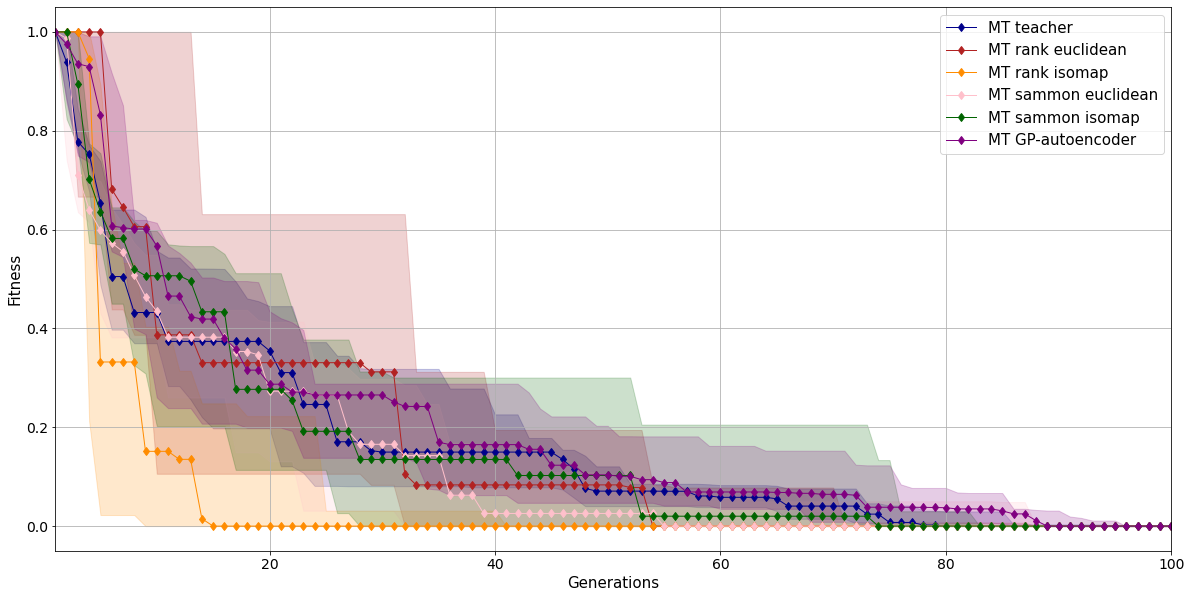

/home/thomas/anaconda3/envs/conda_tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/thomas/anaconda3/envs/conda_tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


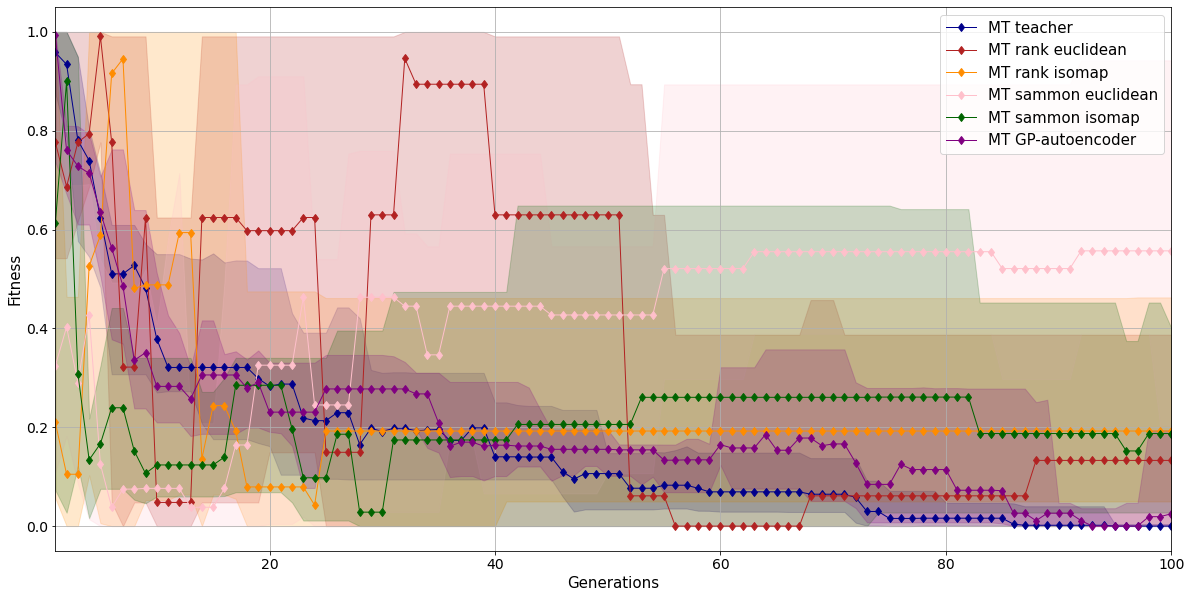

In [43]:
# plot for fitness vs generation

for mode in ["training", "testing"]:
    
    plt.figure(figsize=(20,10))

    my_range = np.arange(1, 101, 1)
    plt.xlim(1, 100)
    plt.ylabel("Fitness", size=15)
    plt.xlabel("Generations", size=15)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.grid()

    color_array = ["darkblue", "firebrick", "darkorange", "pink", "darkgreen", "purple"]
    color_array = color_array[:len(gp_fitness_training_error)]

    for index in range(len(gp_fitness_training_error)):
        
        if mode == "training":
            data = standardize(gp_fitness_training_error[index])
            print(data)
        else:
            data = standardize(gp_fitness_testing_error[index])

        median, low_quantile, high_quantile = get_quantile(data, 0.25)
    
        plt.plot(my_range, median, color=color_array[index], marker="d", markevery=1, markersize=6, linewidth=1)
        plt.fill_between(my_range, np.array(low_quantile).astype('float64'), np.array(high_quantile).astype('float64'), 
                         color=color_array[index], alpha=0.2)

    list_method = ["MT teacher",
                   "MT rank euclidean",
                   "MT rank isomap",
                   "MT sammon euclidean",
                   "MT sammon isomap",
                   "MT GP-autoencoder"]

    leg = plt.legend(list_method, fontsize=15)

    for legobj in leg.get_lines():
        legobj.set_linewidth(1.0)

    plt.savefig("fitness_" + mode + "_" + dataset + "_D=" + str(dimensions[0]) + "_pop=1000", dpi=600)
    plt.show()

# Look at the trees

In [18]:
from sympy import simplify

In [19]:
dim = 2

In [110]:
def extract_quantiles(data, count):
    if count == 0:
        data *= -1
    
    data = np.argsort(data)
    median_index, champion_index, worst_index = data[int(len(data)*0.5)], data[0], data[-1]
    
    return median_index, champion_index, worst_index
    

In [ ]:
def extract_expressions(my_string):
    
    list_expression = []

    for substring in my_string.split(";"):
        
        try:
            if any(char.isdigit() for char in substring):

                start_index = substring.index("(")
                expression = substring[start_index:]
                list_expression.append(simplify(expression))
        except ValueError:
            list_expression.append(substring)
            
    return list_expression

In [131]:
dic_methods = {}

for k, v in dic_gp_metrics.items():
    count_metric = 0
    count_method = 0
    
    dic_metrics = {}
    gp_expr = gp_formulas[count_method]
    for metric_data in dic_gp_metrics[k]:
        if count_metric != 1:
            median_index, champion_index, worst_index = extract_quantiles(np.array(metric_data), count)
        
            worst_tree = extract_expressions(gp_expr[worst_index].GetHumanExpression())[:2]
            median_tree = extract_expressions(gp_expr[median_index].GetHumanExpression())[:2]
            champ_tree = extract_expressions(gp_expr[champion_index].GetHumanExpression())[:2]
            
            dic_metrics[count_metric] = [worst_tree, median_tree, champ_tree]
            
        count_metric += 1
        
    dic_methods[k] = dic_metrics
    count_method += 1

In [132]:
dic_methods

{'results_segmentation_2_mt_not_shared_autoencoder_teacher_fitness_length_pop=200_multi_objective=False.p': {0: [[0.245*x16 + 0.245*x6,
    x18 + x8],
   [x17 - x18 - x6 - x7, x1 - x16 + 3*x18],
   [x18*x8 + 2*x18*(x18 - x6) + 3*x18 + 2*x4 + 2*x5 + x6 + 3*x8,
    '\tsupfun1: x4']],
  2: [[x1 - 4*x11 - 2*x2 + 0.157, -x12 + x17 - 3*x4],
   [x12 + x6, x11*x12 + x12 - 0.706*x15],
   [x17 - x18 - x6 - x7, x1 - x16 + 3*x18]]},
 'results_segmentation_2_mt_not_shared_manifold_fitness_rank_euclidean_length_pop=200_multi_objective=False.p': {0: [[x1 - 4*x11 - 2*x2 + 0.157,
    -x12 + x17 - 3*x4],
   [x10 - x13*x2 + x2, -x18 + x6],
   [0.245*x16 + 0.245*x6, x18 + x8]],
  2: [[x10 - x18, x2 + x5 + x6 + x8],
   [x12 + x6, x11*x12 + x12 - 0.706*x15],
   [x17 - x18 - x6 - x7, x1 - x16 + 3*x18]]},
 'results_segmentation_2_mt_not_shared_manifold_fitness_rank_isomap_length_pop=200_multi_objective=False.p': {0: [[x12 + x6,
    x11*x12 + x12 - 0.706*x15],
   [x17 - x18 - x6 - x7, x1 - x16 + 3*x18],
   [4*